# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical


For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks/TF2_for_DL/1_Getting_started_with_TensorFlow_2/5_Capstone_Project/data')
!ls
!pwd

best_checkpoint.data-00000-of-00001  best_model.index  train_32x32.mat
best_checkpoint.index		     checkpoint
best_model.data-00000-of-00001	     test_32x32.mat
/content/gdrive/MyDrive/Colab_Notebooks/TF2_for_DL/1_Getting_started_with_TensorFlow_2/5_Capstone_Project/data


In [4]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/Colab_Notebooks/TF2_for_DL/1_Getting_started_with_TensorFlow_2/5_Capstone_Project/data/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/Colab_Notebooks/TF2_for_DL/1_Getting_started_with_TensorFlow_2/5_Capstone_Project/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
# Extract the training and testing images and labels and print shapes

x_train, y_train = train['X'], train['y']
x_test, y_test = test['X'], test['y']

x_train = np.moveaxis(x_train, -1, 0) / 255.0 # Move the last dimension to the first and scale
x_test = np.moveaxis(x_test, -1, 0) / 255.0

#y_train = tf.one_hot(y_train, 10) # why don't work???

y_train = train['y'].reshape((x_train.shape[0])) # remove one axis
y_train = to_categorical(y_train, 11) # Convert to one hot encoding
y_train = y_train[:,1:] # Remove 0th column since categories are 1 - 10

y_test = test['y'].reshape((x_test.shape[0]))
y_test = to_categorical(y_test, 11)
y_test = y_test[:,1:] 

y_titles = train['y'] # to printing titles for images

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(73257, 10)
(26032, 32, 32, 3)
(26032, 10)


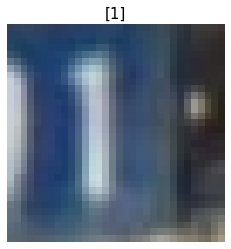

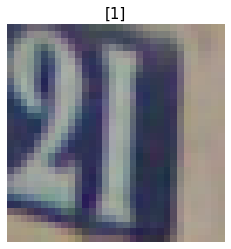

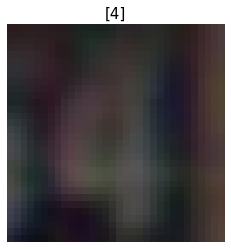

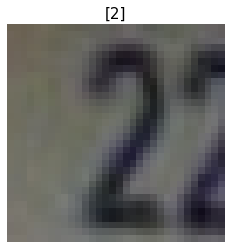

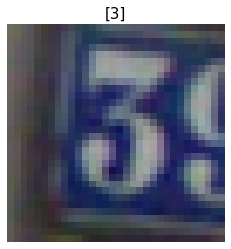

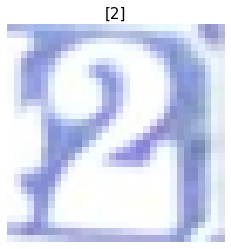

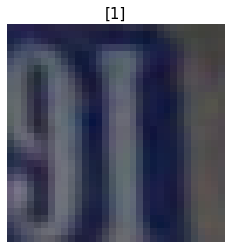

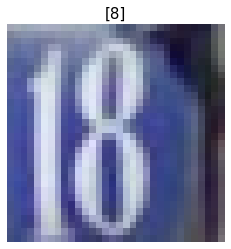

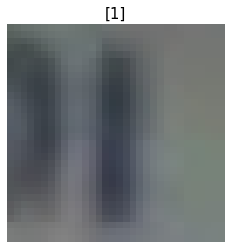

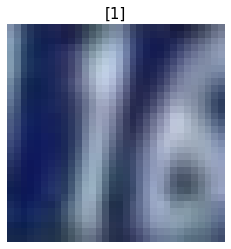

In [6]:
# Select a random sample of images and corresponding labels from the dataset 
# (at least 10), and display them in a figure.

def random_samples(num_samples):
    a = [None] * num_samples
    for i in range(num_samples):
        a = np.random.randint(1, x_train.shape[0])
        img = x_train[a, :, :, :]
        if img.shape[2] == 1:
            plt.imshow(img[:, :, 0], cmap='gray')
        else:
            plt.imshow(img)
        plt.title(str(y_titles[a, :]), fontsize=15)
        plt.axis('off')
        plt.show()
        
random_samples(10)

In [7]:
# Convert the training and test images to grayscale by taking the average
# across all colour channels for each pixel.

def convert_img(x_data):
    img_gray = np.full((x_data.shape[0], 32, 32, 1), 0.0)
    i = 0
    while i < x_data.shape[0]:
        img_gray[i] = np.mean(x_data[i, :, :, :], axis=2, keepdims=1)
        i += 1
    return img_gray

x_train = convert_img(x_train)
x_test = convert_img(x_test)

print(x_train.shape)
print(x_test.shape)


(73257, 32, 32, 1)
(26032, 32, 32, 1)


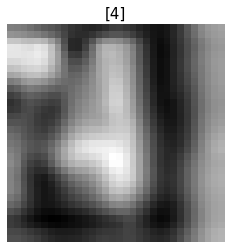

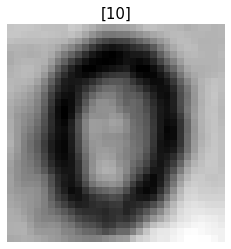

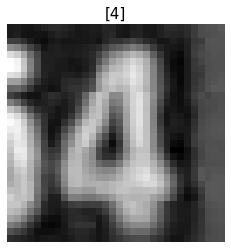

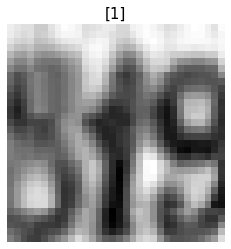

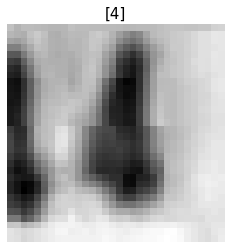

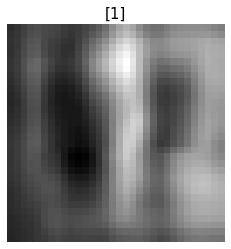

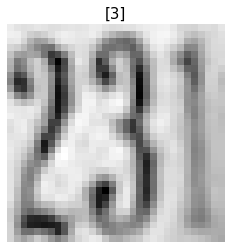

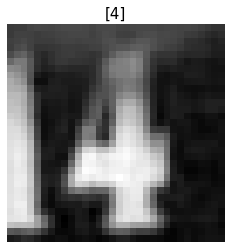

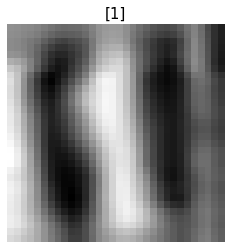

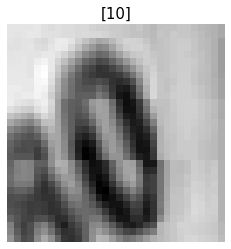

In [8]:
# Select a random sample of the grayscale images and corresponding labels from
# the dataset (at least 10), and display them in a figure.

random_samples(10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
# An MLP classifier model using the Sequential API. 
# Only Flatten and Dense layers, the final layer with a 10-way softmax output.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

regularizer = tf.keras.regularizers.l2
initializer = tf.keras.initializers.glorot_uniform

def get_MLP_classifier():
    model = Sequential([
        Flatten(input_shape=(32, 32, 1), name='flatten'),
        Dense(units=128, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='dense_1'),
        Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='dense_2'),
        Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='dense_3'),
        Dense(units=10, activation='softmax', name='dense_4')
    ])
    return model
    
model = get_MLP_classifier()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile and train the model (we recommend a maximum of 30 epochs), making 
# use of both training and validation sets during the training run. 

from tensorflow.keras.optimizers import Adam

def modelCompile():
    model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

modelCompile()

In [11]:

# Create callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoit_path = 'best_checkpoint'

model_checkpoint = ModelCheckpoint(filepath=checkpoit_path, 
                                        save_weights_only=True,
                                        save_best_only=True, 
                                        monitor='accuracy')

early_stopping_callback = EarlyStopping(monitor='accuracy', 
                                        patience=5,
                                        verbose=1)


callbacks = [model_checkpoint, early_stopping_callback]


In [12]:
# Train the model

history = model.fit(x=x_train, y=y_train, epochs=30, validation_split=0.15,
                    batch_size=128, callbacks=callbacks,verbose=1)


Epoch 1/30
487/487 [==============================] - 5s 7ms/step - loss: 2.2481 - accuracy: 0.1920 - val_loss: 2.1348 - val_accuracy: 0.2442
Epoch 2/30
487/487 [==============================] - 3s 7ms/step - loss: 1.8103 - accuracy: 0.3721 - val_loss: 1.5800 - val_accuracy: 0.4628
Epoch 3/30
487/487 [==============================] - 3s 7ms/step - loss: 1.4833 - accuracy: 0.5068 - val_loss: 1.4127 - val_accuracy: 0.5416
Epoch 4/30
487/487 [==============================] - 3s 7ms/step - loss: 1.3104 - accuracy: 0.5802 - val_loss: 1.2667 - val_accuracy: 0.5912
Epoch 5/30
487/487 [==============================] - 4s 7ms/step - loss: 1.2086 - accuracy: 0.6208 - val_loss: 1.1942 - val_accuracy: 0.6280
Epoch 6/30
487/487 [==============================] - 3s 7ms/step - loss: 1.1420 - accuracy: 0.6482 - val_loss: 1.1432 - val_accuracy: 0.6490
Epoch 7/30
487/487 [==============================] - 3s 6ms/step - loss: 1.1099 - accuracy: 0.6596 - val_loss: 1.1490 - val_accuracy: 0.6430
Epoch 

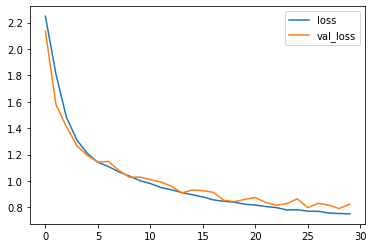

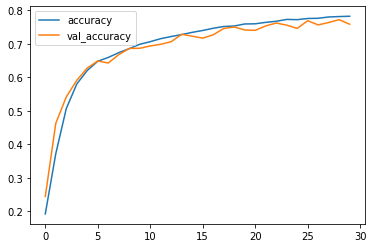

In [13]:
#Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.

import pandas as pd

def plot_learning_curves():
    df = pd.DataFrame(history.history)
    df.plot(y=['loss', 'val_loss'])
    df.plot(y=['accuracy', 'val_accuracy'])

plot_learning_curves()

In [14]:
# Compute and display the loss and accuracy of the trained model on the test set.

model.evaluate(x=x_test, y=y_test, verbose=2)

814/814 - 1s - loss: 0.8969 - accuracy: 0.7459


[0.8968841433525085, 0.7458512783050537]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
# Build a CNN classifier model using the Sequential API. Your model should use 
# the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. 
# Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 
# convolutional layers and 2 fully connected layers.)

from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout

def get_CNN_classifier():
    model = Sequential([
                        Conv2D(filters=64, input_shape=(32, 32, 1), kernel_size=(3, 3), 
                               activation='relu', name='conv_1'),
                        MaxPool2D(pool_size=(2,2)),
                        Dropout(0.3),
                        BatchNormalization(),
                        Conv2D(32, kernel_size=3, activation='relu'),
                        MaxPool2D(pool_size=(2,2)),
                        Dropout(0.3),
                        BatchNormalization(),
                        Flatten(),
                        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                        BatchNormalization(),
                        Dense(10, activation='softmax')
    ])  
    return(model) 
    

In [16]:
model = get_CNN_classifier()
modelCompile()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)         

In [17]:
# Train the model

history = model.fit(x=x_train, y=y_train, epochs=10, validation_split=0.15,
                    batch_size=128, callbacks=callbacks,verbose=1)

Epoch 1/10
487/487 [==============================] - 111s 226ms/step - loss: 1.4440 - accuracy: 0.5307 - val_loss: 2.0896 - val_accuracy: 0.1701
Epoch 2/10
487/487 [==============================] - 111s 229ms/step - loss: 0.7060 - accuracy: 0.7857 - val_loss: 0.5539 - val_accuracy: 0.8401
Epoch 3/10
487/487 [==============================] - 109s 223ms/step - loss: 0.6140 - accuracy: 0.8125 - val_loss: 0.5329 - val_accuracy: 0.8479
Epoch 4/10
487/487 [==============================] - 110s 225ms/step - loss: 0.5778 - accuracy: 0.8241 - val_loss: 0.4891 - val_accuracy: 0.8565
Epoch 5/10
487/487 [==============================] - 110s 225ms/step - loss: 0.5569 - accuracy: 0.8320 - val_loss: 0.4840 - val_accuracy: 0.8606
Epoch 6/10
487/487 [==============================] - 110s 226ms/step - loss: 0.5365 - accuracy: 0.8368 - val_loss: 0.4459 - val_accuracy: 0.8718
Epoch 7/10
487/487 [==============================] - 109s 225ms/step - loss: 0.5282 - accuracy: 0.8375 - val_loss: 0.4607 -

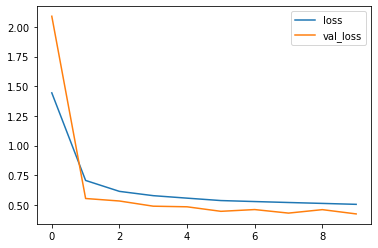

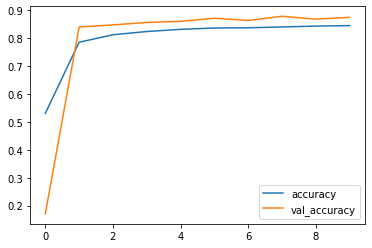

In [18]:
plot_learning_curves()

In [19]:
# Compute and display the loss and accuracy of the trained model on the test set.

model.evaluate(x=x_test, y=y_test, verbose=2)

814/814 - 9s - loss: 0.4621 - accuracy: 0.8639


[0.4621396064758301, 0.8638982772827148]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [20]:
from tensorflow.keras.models import load_model

model.load_weights('best_checkpoint')

In [29]:
# Randomly select 5 images and corresponding labels from the test set and display 
# the images with their labels.
# Alongside the image and label, show each model’s predictive distribution as a 
# bar chart, and the final model prediction given by the label with maximum probability.

test_y_sparse = np.array(test['y'])
test_y_sparse = test_y_sparse.reshape((x_test.shape[0])) 

def print_random_samples(num_samples, data_X, data_y, data_y_sparse):

    random_index = np.random.choice(data_X.shape[0], num_samples)
    random_test_images = data_X[random_index, ...]
    random_test_labels = data_y_sparse[random_index, ...]
    predictions = model.predict(random_test_images)

    for i in range(0, num_samples):
        img = random_test_images[i]
        label = random_test_labels[i]
        prediction = predictions[i]
        pred_label = prediction.argmax() + 1
        pred_prob = prediction[pred_label - 1]
        print(f"Test Sample with Label {label}")

        fig = plt.figure(figsize=(12, 5))

        fig.add_subplot(121)
        plt.imshow(img[:, :, 0], cmap='gray')

        ax2 = fig.add_subplot(122)
        ax2.set_xticks(np.arange(len(prediction)+1))

        plt.bar(list(range(1,11)), prediction, color='blue')
        # plt.hist(prediction, bins=10, histtype='bar', rwidth=0.8)

        plt.xlabel('Digits')
        plt.ylabel('Prediction Weights')
        plt.title(f"Predicted {pred_label} with Probability {pred_prob:0.2f} for Label {label}")
        plt.show()

Test Sample with Label 6


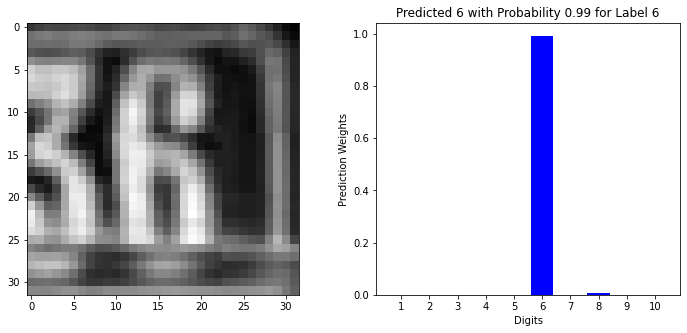

Test Sample with Label 4


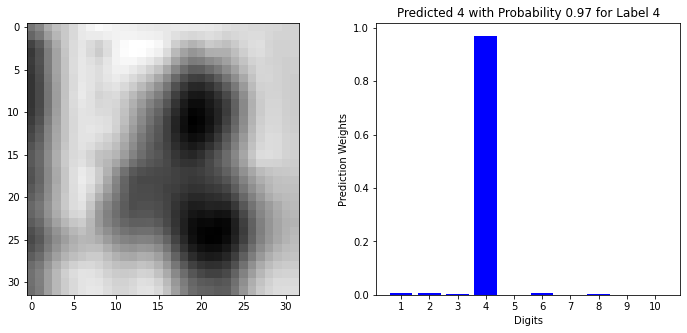

Test Sample with Label 1


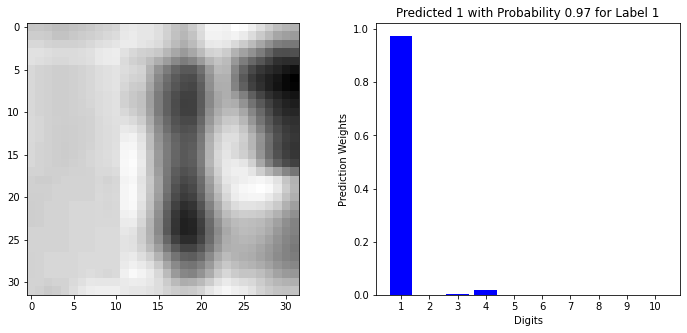

Test Sample with Label 2


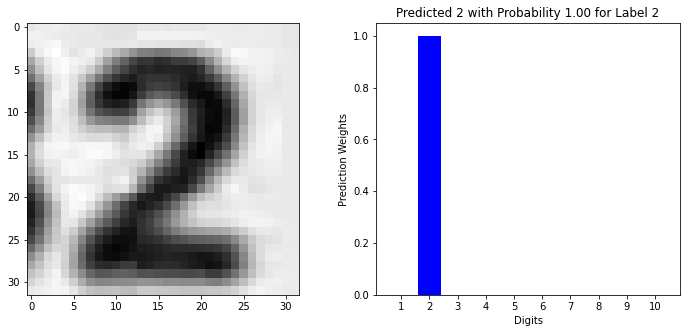

Test Sample with Label 7


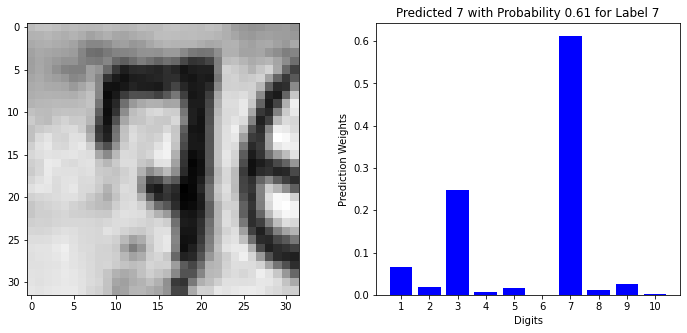

In [30]:
print_random_samples(5, x_test, y_test, test_y_sparse)